In [1]:
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
import os
import numpy as np
from keras.applications.imagenet_utils import preprocess_input 
from keras.utils import np_utils
import random
import pprint
import cPickle
# from scipy.misc import imread, imresize, imsave
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.engine.topology import Merge, merge
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.visualize_util import plot
from scipy.ndimage.filters import gaussian_filter as gauss
from keras.models import load_model
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
tl_model1 = load_model('./90percentModels/model100')
tl_model2 = load_model('./90percentModels/model300')
tl_model3 = load_model('./90percentModels/model500')

tl_model11 = load_model('./modelDeep/modelDeep100')
tl_model21 = load_model('./modelDeep/modelDeep300')
tl_model31 = load_model('./modelDeep/modelDeep500')

In [4]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
#     xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    return np.uint8(rgb.dot(xform.T))

In [5]:
random.seed(0)

X_test = []
Y_test = []
actual_image = []

counter = 0
for directory in os.listdir('./testData/'):
#     l = os.listdir('./mitData/' + directory)
    for (index,image) in enumerate(os.listdir('./testData/' + directory)):        
#         image = l[0]
        img = load_img('./testData/' + directory + '/' + image, target_size=(224,224))  # this is a PIL image
        x = img_to_array(img)
        actual_image.append(img)
        x = rgb2ycbcr(x)
        Y_test.append(x[:,:,1:])
        X_test.append(x[:,:,:1])
X_test = np.array(X_test)
X_test = np.array(X_test)

In [6]:
XX_test = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3] + 2))
XX_test[:,:,:,0:] = X_test
XX_test.shape

(133, 224, 224, 3)

In [7]:
model1_predictions = tl_model11.predict(XX_test)[3]
model2_predictions = tl_model21.predict(XX_test)[3]
model3_predictions = tl_model31.predict(XX_test)[3]

In [12]:
model1_predictions1 = tl_model1.predict(XX_test)
model2_predictions1 = tl_model2.predict(XX_test)
model3_prediction1 = tl_model3.predict(XX_test)

In [ ]:
# prediction1 = tl_model2.predict(XX_test[1:2,:,:,:])

# prediction1 = prediction1.reshape(224,224,2)
# p = np.append(XX_test[1,:,:,0:1], prediction1, axis=2)
# b = ycbcr2rgb(p)
# plt.imshow(b)

In [ ]:
# median_filter(b)
# plt.imshow(b)

In [8]:
lower = 255
higher = 240
def check_filter(i,j, img):
    if  (img[i,j,0] > 240 and img[i,j,1] >  higher and img[i,j,2] <= lower) or \
        (img[i,j,1] > 240 and img[i,j,2] >  higher and img[i,j,0] <= lower) or \
        (img[i,j,0] > 240 and img[i,j,2] >  higher and img[i,j,1] <= lower) or \
        (img[i,j,0] > 240 and img[i,j,1] <= lower and img[i,j,2] <= lower) or \
        (img[i,j,1] > 240 and img[i,j,2] <= lower and img[i,j,0] <= lower) or \
        (img[i,j,2] > 240 and img[i,j,0] <= lower and img[i,j,1] <= lower):
            return True
    return False

def apply_filter(i,j, filter_size, img):
    row_start = (0 if i-filter_size < 0 else i-filter_size)
    row_end =  (len(img) if i+filter_size+1 > len(img) else i+filter_size+1)
    col_start = (0 if j-filter_size < 0 else j-filter_size)
    col_end = (len(img[0]) if j+filter_size+1 > len(img[0]) else j+filter_size+1)
    img[i,j, 0] = np.median(img[row_start : row_end, col_start : col_end, 0])
    img[i,j, 1] = np.median(img[row_start : row_end, col_start : col_end, 1])
    img[i,j, 2] = np.median(img[row_start : row_end, col_start : col_end, 2])
    
def median_filter(img):
    filter_size  = 2
    oldVal = -1
    while True:
        c = 0
        for i in range(0,224):
            for j in range(0,224):
                if(check_filter(i,j,b)):
                    c+=1
                    apply_filter(i,j,filter_size,b)
        if c == oldVal:
            break
        oldVal = c

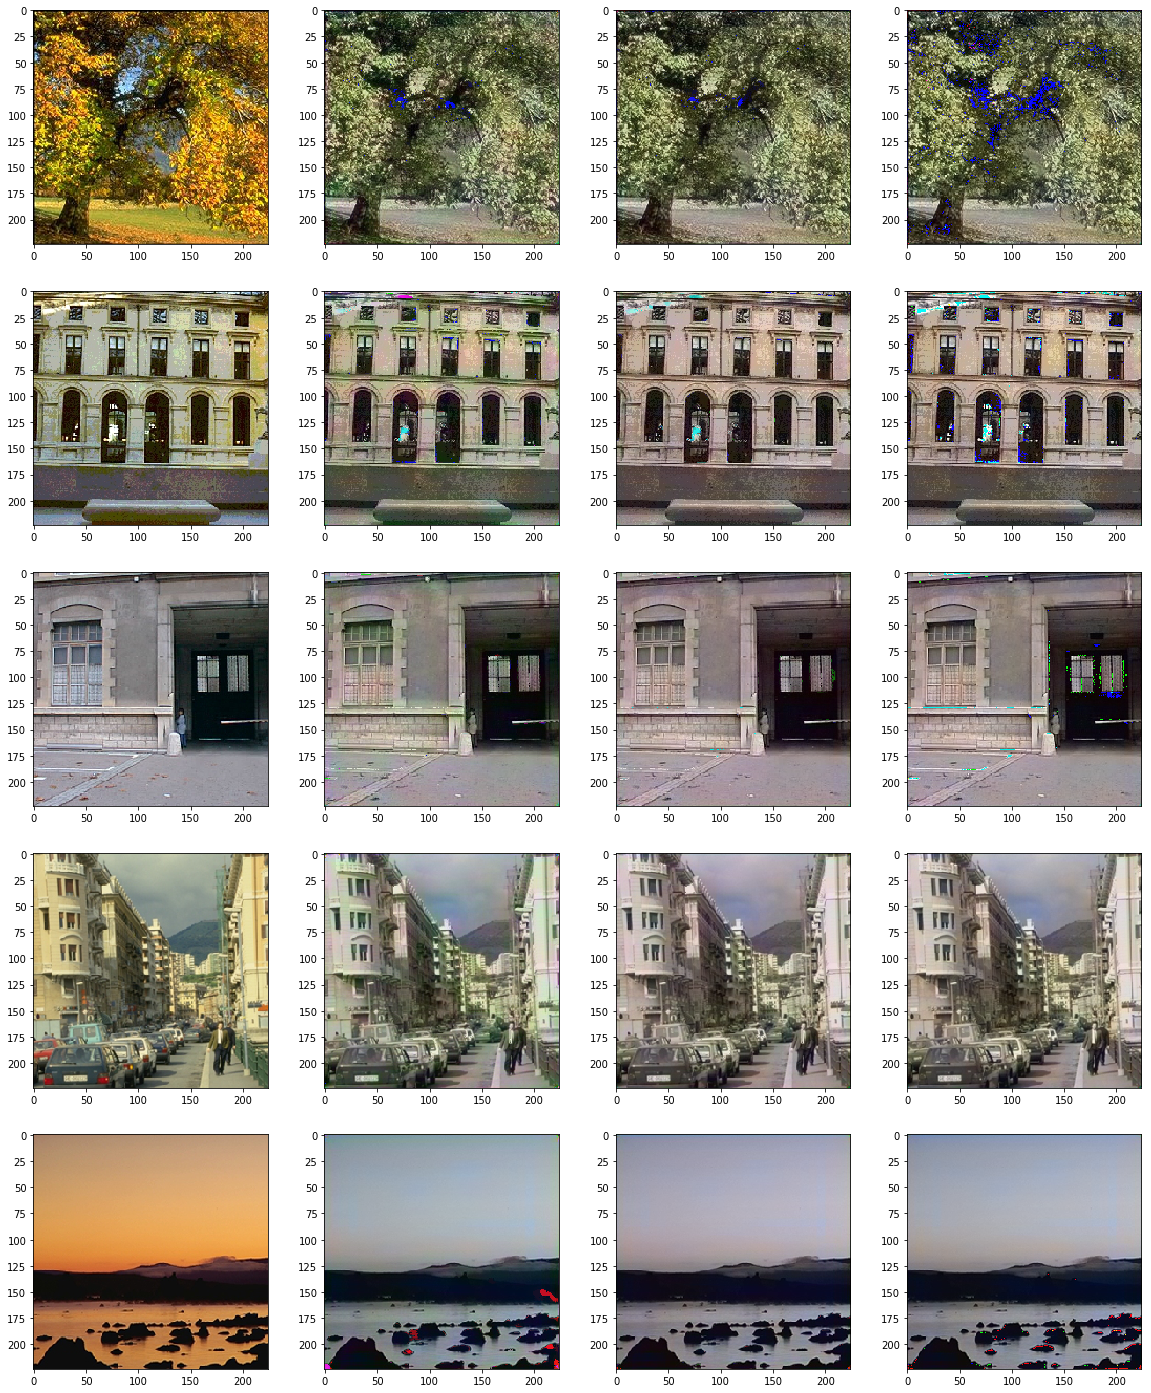

In [13]:
# total_images = len(model2_predictions)
BAD_IDX = [4,9,12,17,-1]
GOOD_IDX = [1,11,13,15,-7]

total_images = 5
idx_list = [1,9,12,15,16,31,32,34,37,38,50,53,55,57,59,67,90,91,92,93,95,101,103,104,106,107,113,122,124,125,130]

pylab.rcParams['figure.figsize'] = (20, total_images*5)
# for val, i in enumerate([1,9,12,15,16,31,32,34,37,38,50,53,55,57,59,67,90,91,92,93,95,101,103,104,106,107,113,122,124,125,130]):
for val, i in enumerate(GOOD_IDX):
    i = idx_list[i]
    val +=1
    plt.subplot(total_images,4,1+4*(val-1))
    plt.imshow(actual_image[i])
    
    plt.subplot(total_images,4,2+4*(val-1))
    model1_predictions[i] = model1_predictions[i].reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model1_predictions[i], axis=2)
    b = ycbcr2rgb(p)
    median_filter(b)
    plt.imshow(b)

#     plt.subplot(total_images,4,3+4*(i-1))
#     model1_predictions[i] = mode12_predictions[i]
#     p = np.append(XX_test[i,:,:,0:1], model1_predictions[i], axis=2)
#     b = ycbcr2rgb(p)
#     median_filter(b)
#     plt.imshow(b)
    
    plt.subplot(total_images,4,3+4*(val-1))
    model2_predictions[i] = model2_predictions[i]#.reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model2_predictions[i], axis=2)
    b = ycbcr2rgb(p)
    median_filter(b)
    plt.imshow(b)
    
    
    plt.subplot(total_images,4,4+4*(val-1))
    model3_predictions[i] = model3_predictions[i]#.reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model3_predictions[i], axis=2)
    d = ycbcr2rgb(p)
    median_filter(b)
    plt.imshow(d)
#     plt.imshow(XX_test[i,:,:,0],cmap='gray')
    
plt.savefig('./outputDeepFiltered2_100_300_500_good.jpg')

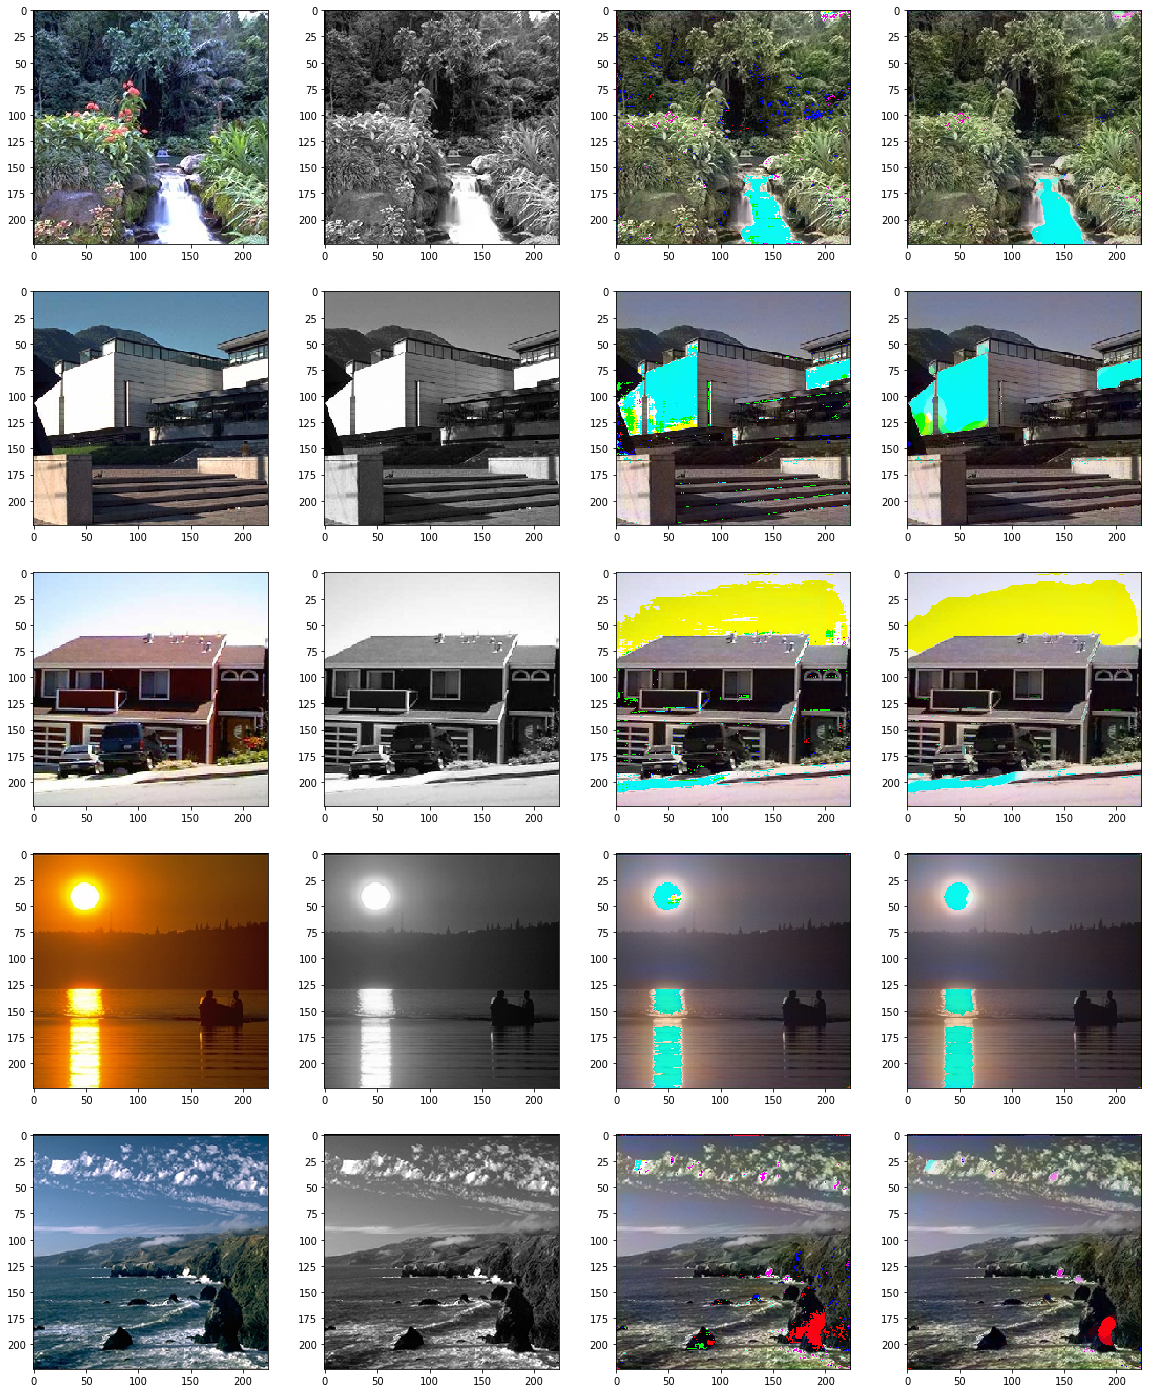

In [10]:
BAD_IDX = [4,9,12,17,-1]
GOOD_IDX = [1,11,13,15,-7]

total_images = 5
idx_list = [1,9,12,15,16,31,32,34,37,38,50,53,55,57,59,67,90,91,92,93,95,101,103,104,106,107,113,122,124,125,130]

pylab.rcParams['figure.figsize'] = (20, total_images*5)
# for val, i in enumerate([1,9,12,15,16,31,32,34,37,38,50,53,55,57,59,67,90,91,92,93,95,101,103,104,106,107,113,122,124,125,130]):
for val, i in enumerate(BAD_IDX):
    i = idx_list[i]
    val +=1
    plt.subplot(total_images,4,1+4*(val-1))
    plt.imshow(actual_image[i])
    
    plt.subplot(total_images,4,3+4*(val-1))
    model2_predictions[i] = model2_predictions[i].reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model2_predictions[i], axis=2)
    b = ycbcr2rgb(p)
    plt.imshow(b)

#     plt.subplot(total_images,4,3+4*(i-1))
#     model1_predictions[i] = mode12_predictions[i]
#     p = np.append(XX_test[i,:,:,0:1], model1_predictions[i], axis=2)
#     b = ycbcr2rgb(p)
#     median_filter(b)
#     plt.imshow(b)
    
    plt.subplot(total_images,4,4+4*(val-1))
    model2_predictions[i] = model2_predictions[i]#.reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model2_predictions[i], axis=2)
    b = ycbcr2rgb(p)
    median_filter(b)
    plt.imshow(b)
    
    
    plt.subplot(total_images,4,2+4*(val-1))
#     model3_predictions[i] = model3_predictions[i]#.reshape(224,224,2)
#     p = np.append(XX_test[i,:,:,0:1], model3_predictions[i], axis=2)
#     d = ycbcr2rgb(p)
#     plt.imshow(d)
    plt.imshow(XX_test[i,:,:,0],cmap='gray')
    
plt.savefig('./outputDeep300_med_bad.jpg')

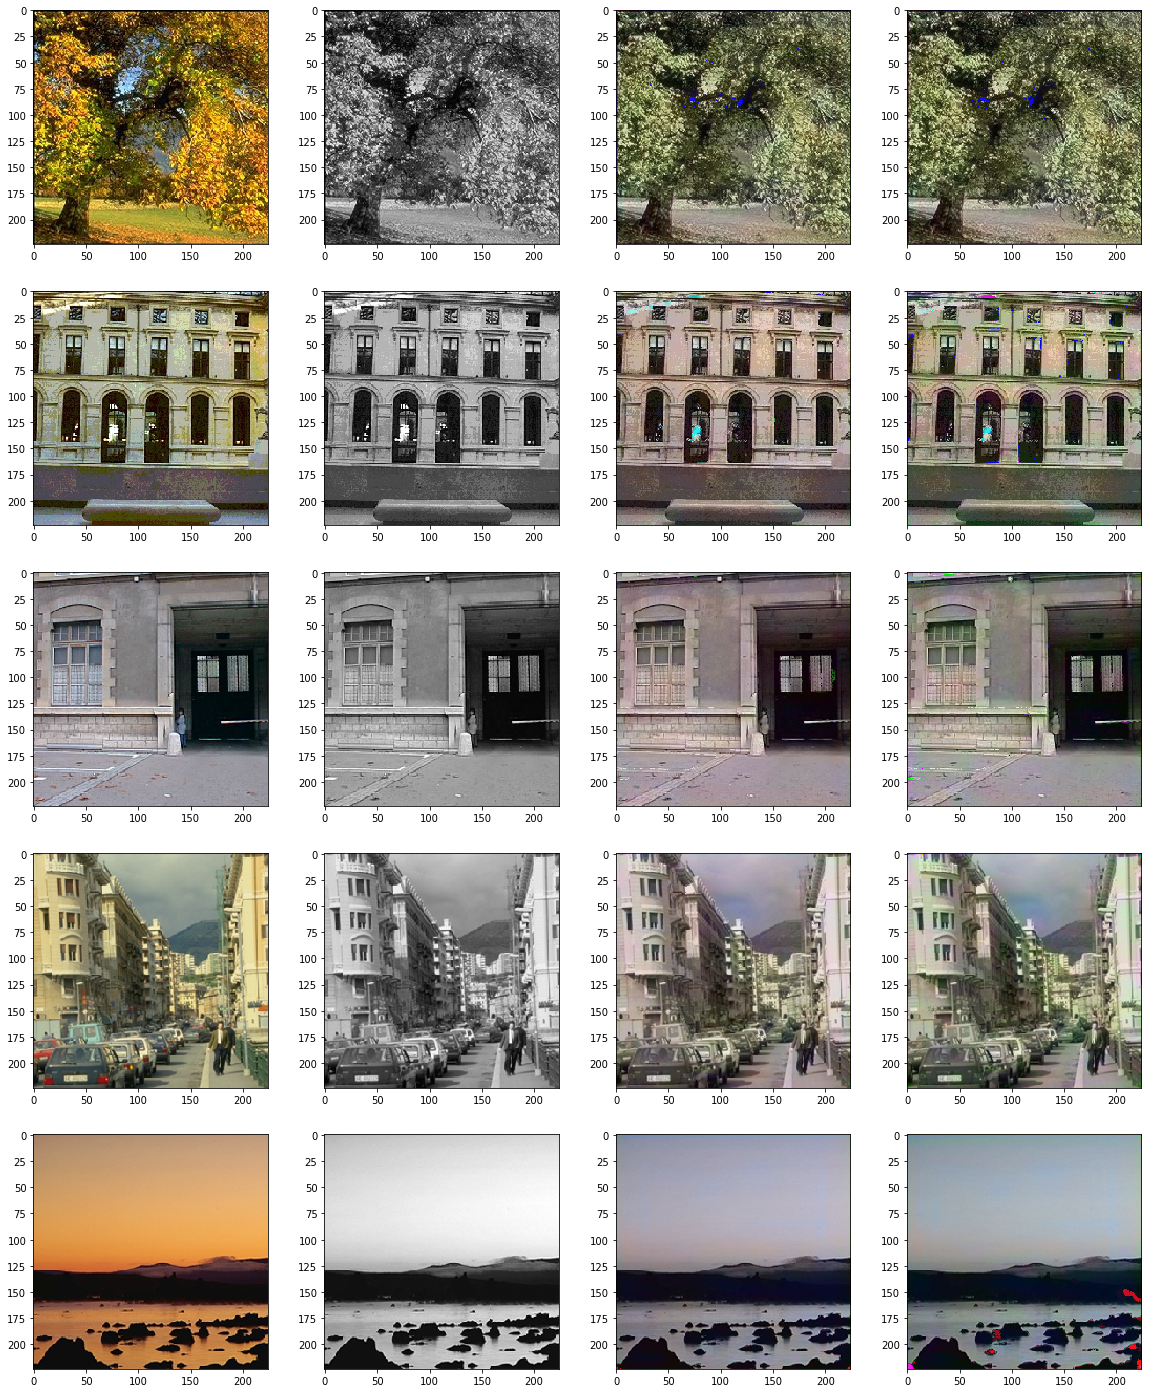

In [16]:
# total_images = len(model2_predictions)
BAD_IDX = [4,9,12,17,-1]
GOOD_IDX = [1,11,13,15,-7]

total_images = 5
idx_list = [1,9,12,15,16,31,32,34,37,38,50,53,55,57,59,67,90,91,92,93,95,101,103,104,106,107,113,122,124,125,130]

pylab.rcParams['figure.figsize'] = (20, total_images*5)
# for val, i in enumerate([1,9,12,15,16,31,32,34,37,38,50,53,55,57,59,67,90,91,92,93,95,101,103,104,106,107,113,122,124,125,130]):
for val, i in enumerate(GOOD_IDX):
    i = idx_list[i]
    val +=1
    plt.subplot(total_images,4,1+4*(val-1))
    plt.imshow(actual_image[i])
    
    plt.subplot(total_images,4,4+4*(val-1))
    model2_predictions1[i] = model2_predictions1[i].reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model1_predictions[i], axis=2)
    b = ycbcr2rgb(p)
    median_filter(b)
    plt.imshow(b)

#     plt.subplot(total_images,4,3+4*(i-1))
#     model1_predictions[i] = mode12_predictions[i]
#     p = np.append(XX_test[i,:,:,0:1], model1_predictions[i], axis=2)
#     b = ycbcr2rgb(p)
#     median_filter(b)
#     plt.imshow(b)
    
    plt.subplot(total_images,4,3+4*(val-1))
    model2_predictions[i] = model2_predictions[i]#.reshape(224,224,2)
    p = np.append(XX_test[i,:,:,0:1], model2_predictions[i], axis=2)
    b = ycbcr2rgb(p)
    median_filter(b)
    plt.imshow(b)
    
    
#     plt.subplot(total_images,4,4+4*(val-1))
#     model3_predictions[i] = model3_predictions[i]#.reshape(224,224,2)
#     p = np.append(XX_test[i,:,:,0:1], model3_predictions[i], axis=2)
#     d = ycbcr2rgb(p)
#     median_filter(b)
#     plt.imshow(d)
    
    plt.subplot(total_images,4,2+4*(val-1))
#     model3_predictions[i] = model3_predictions[i]#.reshape(224,224,2)
#     p = np.append(XX_test[i,:,:,0:1], model3_predictions[i], axis=2)
#     d = ycbcr2rgb(p)
#     plt.imshow(d)
    plt.imshow(XX_test[i,:,:,0],cmap='gray')
    
#     plt.imshow(XX_test[i,:,:,0],cmap='gray')
    
plt.savefig('./output_comp_300_good.jpg')